In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.9,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_09_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/793 [..............................] - ETA: 15:42 - loss: 0.0197 - STD: 1.1587e-04 - MAE: 0.1237

 11/793 [..............................] - ETA: 4s - loss: 0.0137 - STD: 4.0597e-04 - MAE: 0.0912   

 20/793 [..............................] - ETA: 4s - loss: 0.0120 - STD: 5.3415e-04 - MAE: 0.0844

 28/793 [>.............................] - ETA: 4s - loss: 0.0112 - STD: 6.8586e-04 - MAE: 0.0822

 37/793 [>.............................] - ETA: 4s - loss: 0.0107 - STD: 8.6652e-04 - MAE: 0.0804

 46/793 [>.............................] - ETA: 4s - loss: 0.0104 - STD: 0.0012 - MAE: 0.0797    

 55/793 [=>............................] - ETA: 4s - loss: 0.0102 - STD: 0.0016 - MAE: 0.0788

 64/793 [=>............................] - ETA: 4s - loss: 0.0100 - STD: 0.0024 - MAE: 0.0781

 72/793 [=>............................] - ETA: 4s - loss: 0.0098 - STD: 0.0037 - MAE: 0.0774

 81/793 [==>...........................] - ETA: 4s - loss: 0.0096 - STD: 0.0063 - MAE: 0.0765

 90/793 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 0.0096 - MAE: 0.0756

 99/793 [==>...........................] - ETA: 4s - loss: 0.0091 - STD: 0.0125 - MAE: 0.0748

108/793 [===>..........................] - ETA: 4s - loss: 0.0089 - STD: 0.0150 - MAE: 0.0740

117/793 [===>..........................] - ETA: 4s - loss: 0.0088 - STD: 0.0173 - MAE: 0.0732

125/793 [===>..........................] - ETA: 4s - loss: 0.0087 - STD: 0.0192 - MAE: 0.0727

134/793 [====>.........................] - ETA: 3s - loss: 0.0085 - STD: 0.0211 - MAE: 0.0720

143/793 [====>.........................] - ETA: 3s - loss: 0.0084 - STD: 0.0228 - MAE: 0.0714

152/793 [====>.........................] - ETA: 3s - loss: 0.0083 - STD: 0.0243 - MAE: 0.0708

160/793 [=====>........................] - ETA: 3s - loss: 0.0082 - STD: 0.0256 - MAE: 0.0703

169/793 [=====>........................] - ETA: 3s - loss: 0.0081 - STD: 0.0271 - MAE: 0.0697

178/793 [=====>........................] - ETA: 3s - loss: 0.0080 - STD: 0.0285 - MAE: 0.0691

187/793 [======>.......................] - ETA: 3s - loss: 0.0079 - STD: 0.0298 - MAE: 0.0686

196/793 [======>.......................] - ETA: 3s - loss: 0.0078 - STD: 0.0310 - MAE: 0.0681

204/793 [======>.......................] - ETA: 3s - loss: 0.0077 - STD: 0.0321 - MAE: 0.0676

213/793 [=======>......................] - ETA: 3s - loss: 0.0076 - STD: 0.0332 - MAE: 0.0671

222/793 [=======>......................] - ETA: 3s - loss: 0.0075 - STD: 0.0343 - MAE: 0.0667

231/793 [=======>......................] - ETA: 3s - loss: 0.0074 - STD: 0.0353 - MAE: 0.0662

240/793 [========>.....................] - ETA: 3s - loss: 0.0073 - STD: 0.0363 - MAE: 0.0658

249/793 [========>.....................] - ETA: 3s - loss: 0.0072 - STD: 0.0373 - MAE: 0.0653

257/793 [========>.....................] - ETA: 3s - loss: 0.0072 - STD: 0.0381 - MAE: 0.0650

266/793 [=========>....................] - ETA: 3s - loss: 0.0071 - STD: 0.0388 - MAE: 0.0646

275/793 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.0396 - MAE: 0.0642

284/793 [=========>....................] - ETA: 3s - loss: 0.0070 - STD: 0.0403 - MAE: 0.0639

293/793 [==========>...................] - ETA: 2s - loss: 0.0069 - STD: 0.0410 - MAE: 0.0635

301/793 [==========>...................] - ETA: 2s - loss: 0.0068 - STD: 0.0416 - MAE: 0.0632

310/793 [==========>...................] - ETA: 2s - loss: 0.0068 - STD: 0.0422 - MAE: 0.0629

319/793 [===========>..................] - ETA: 2s - loss: 0.0067 - STD: 0.0429 - MAE: 0.0626

328/793 [===========>..................] - ETA: 2s - loss: 0.0067 - STD: 0.0435 - MAE: 0.0623

337/793 [===========>..................] - ETA: 2s - loss: 0.0066 - STD: 0.0441 - MAE: 0.0620

346/793 [============>.................] - ETA: 2s - loss: 0.0066 - STD: 0.0447 - MAE: 0.0618

354/793 [============>.................] - ETA: 2s - loss: 0.0065 - STD: 0.0450 - MAE: 0.0616

363/793 [============>.................] - ETA: 2s - loss: 0.0065 - STD: 0.0455 - MAE: 0.0613

372/793 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.0460 - MAE: 0.0611

381/793 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.0466 - MAE: 0.0608

390/793 [=============>................] - ETA: 2s - loss: 0.0064 - STD: 0.0470 - MAE: 0.0606

399/793 [==============>...............] - ETA: 2s - loss: 0.0063 - STD: 0.0475 - MAE: 0.0604

404/793 [==============>...............] - ETA: 2s - loss: 0.0063 - STD: 0.0477 - MAE: 0.0603

415/793 [==============>...............] - ETA: 2s - loss: 0.0063 - STD: 0.0481 - MAE: 0.0601

424/793 [===============>..............] - ETA: 2s - loss: 0.0062 - STD: 0.0484 - MAE: 0.0599

433/793 [===============>..............] - ETA: 2s - loss: 0.0062 - STD: 0.0488 - MAE: 0.0597

441/793 [===============>..............] - ETA: 2s - loss: 0.0061 - STD: 0.0492 - MAE: 0.0595

450/793 [================>.............] - ETA: 2s - loss: 0.0061 - STD: 0.0496 - MAE: 0.0593

459/793 [================>.............] - ETA: 2s - loss: 0.0061 - STD: 0.0499 - MAE: 0.0590

468/793 [================>.............] - ETA: 2s - loss: 0.0060 - STD: 0.0503 - MAE: 0.0588

477/793 [=================>............] - ETA: 2s - loss: 0.0060 - STD: 0.0507 - MAE: 0.0586

485/793 [=================>............] - ETA: 2s - loss: 0.0060 - STD: 0.0510 - MAE: 0.0585

494/793 [=================>............] - ETA: 2s - loss: 0.0060 - STD: 0.0512 - MAE: 0.0586

503/793 [==================>...........] - ETA: 2s - loss: 0.0060 - STD: 0.0511 - MAE: 0.0587

512/793 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0510 - MAE: 0.0587

521/793 [==================>...........] - ETA: 1s - loss: 0.0060 - STD: 0.0511 - MAE: 0.0586

529/793 [===================>..........] - ETA: 1s - loss: 0.0060 - STD: 0.0513 - MAE: 0.0585

538/793 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0515 - MAE: 0.0583

547/793 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0518 - MAE: 0.0582

556/793 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0521 - MAE: 0.0580

565/793 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0524 - MAE: 0.0579

574/793 [====================>.........] - ETA: 1s - loss: 0.0058 - STD: 0.0527 - MAE: 0.0577

582/793 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0529 - MAE: 0.0576

591/793 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0532 - MAE: 0.0575

600/793 [=====================>........] - ETA: 1s - loss: 0.0058 - STD: 0.0534 - MAE: 0.0573

609/793 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0537 - MAE: 0.0572

618/793 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0539 - MAE: 0.0571

627/793 [======================>.......] - ETA: 1s - loss: 0.0057 - STD: 0.0542 - MAE: 0.0569

635/793 [=======================>......] - ETA: 1s - loss: 0.0057 - STD: 0.0544 - MAE: 0.0568

642/793 [=======================>......] - ETA: 1s - loss: 0.0057 - STD: 0.0545 - MAE: 0.0567

651/793 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0547 - MAE: 0.0566

660/793 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0549 - MAE: 0.0565

669/793 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0552 - MAE: 0.0564

677/793 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0554 - MAE: 0.0563

686/793 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0556 - MAE: 0.0562

695/793 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0557 - MAE: 0.0561

704/793 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0559 - MAE: 0.0560

713/793 [=========================>....] - ETA: 0s - loss: 0.0055 - STD: 0.0561 - MAE: 0.0559

722/793 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0563 - MAE: 0.0558

731/793 [==========================>...] - ETA: 0s - loss: 0.0055 - STD: 0.0565 - MAE: 0.0557

740/793 [==========================>...] - ETA: 0s - loss: 0.0054 - STD: 0.0566 - MAE: 0.0556

748/793 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0568 - MAE: 0.0555

756/793 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0554

764/793 [===========================>..] - ETA: 0s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0553

773/793 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0552

782/793 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0574 - MAE: 0.0551

791/793 [============================>.] - ETA: 0s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0551

793/793 [==============================] - 7s 8ms/step - loss: 0.0054 - STD: 0.0576 - MAE: 0.0550 - val_loss: 0.0038 - val_STD: 0.0510 - val_MAE: 0.0444


Epoch 2/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0043 - STD: 0.0654 - MAE: 0.0478

  8/793 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0692 - MAE: 0.0471 

 17/793 [..............................] - ETA: 5s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0487

 26/793 [..............................] - ETA: 4s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0479

 35/793 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0477

 44/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0482

 52/793 [>.............................] - ETA: 4s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0481

 60/793 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0480

 69/793 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

 78/793 [=>............................] - ETA: 4s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0480

 87/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0477

 95/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0476

104/793 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0476

113/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0476

122/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

131/793 [===>..........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0474

139/793 [====>.........................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0473

148/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0472

157/793 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0471

166/793 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0471

175/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

183/793 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0472

192/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0472

201/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0473

210/793 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0472

219/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0472

227/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

236/793 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0471

245/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0471

254/793 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0470

263/793 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0470

272/793 [=========>....................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0469

280/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0470

289/793 [=========>....................] - ETA: 3s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

298/793 [==========>...................] - ETA: 3s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0474

307/793 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0475

316/793 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

324/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0475

333/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0474

342/793 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0707 - MAE: 0.0474

351/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

360/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

368/793 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0472

377/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0472

386/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0471

395/793 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0471

404/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

412/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

421/793 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0470

430/793 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

439/793 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

448/793 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

456/793 [================>.............] - ETA: 2s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

464/793 [================>.............] - ETA: 2s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

473/793 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

482/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0469

491/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0468

499/793 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

507/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

515/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

524/793 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

533/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0467

542/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

551/793 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

560/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

569/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

578/793 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

587/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0466

595/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

604/793 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0466

613/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

622/793 [======================>.......] - ETA: 1s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

630/793 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

638/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0465

647/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0465

656/793 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0719 - MAE: 0.0464

665/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

674/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0464

683/793 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

691/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

700/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

708/793 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0720 - MAE: 0.0463

717/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

726/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0463

734/793 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

742/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

750/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

758/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

766/793 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

775/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0462

784/793 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

793/793 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

793/793 [==============================] - 5s 7ms/step - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462 - val_loss: 0.0031 - val_STD: 0.0588 - val_MAE: 0.0411


Epoch 3/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0033 - STD: 0.0721 - MAE: 0.0430

  8/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0716 - MAE: 0.0437 

 17/793 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0445

 26/793 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0450

 35/793 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0447

 44/793 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0445

 52/793 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

 60/793 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

 69/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

 78/793 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

 87/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

 96/793 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

104/793 [==>...........................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

113/793 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

122/793 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

131/793 [===>..........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

140/793 [====>.........................] - ETA: 4s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

149/793 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

157/793 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

166/793 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

175/793 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

184/793 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0442

193/793 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

201/793 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

210/793 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

219/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

228/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

237/793 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

245/793 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

254/793 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

263/793 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

272/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

281/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

289/793 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

298/793 [==========>...................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

307/793 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

316/793 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

325/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

334/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

342/793 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

351/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

360/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

369/793 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

378/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

387/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

395/793 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

404/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

413/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

422/793 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

431/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

439/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

447/793 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

456/793 [================>.............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

465/793 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

474/793 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

483/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

491/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

500/793 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

509/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

517/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

526/793 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

535/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

542/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

551/793 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

560/793 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

569/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

578/793 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

587/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

596/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

605/793 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

614/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

623/793 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

631/793 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

639/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

647/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

656/793 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

665/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

674/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

682/793 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

690/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0441

699/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

708/793 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

717/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

725/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

734/793 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

743/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

752/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

761/793 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

770/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

778/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

787/793 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

793/793 [==============================] - 5s 7ms/step - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440 - val_loss: 0.0030 - val_STD: 0.0576 - val_MAE: 0.0400


Epoch 4/10000


  1/793 [..............................] - ETA: 17s - loss: 0.0034 - STD: 0.0714 - MAE: 0.0442

  9/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0433 

 17/793 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0436

 25/793 [..............................] - ETA: 5s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

 34/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

 43/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

 52/793 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

 61/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

 70/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

 78/793 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

 87/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

 94/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

100/793 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

107/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

116/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

125/793 [===>..........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

134/793 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

142/793 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

149/793 [====>.........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

154/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

159/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

166/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

174/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

183/793 [=====>........................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

192/793 [======>.......................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

201/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

210/793 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

219/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

228/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

236/793 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

243/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

252/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

261/793 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

270/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

279/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

288/793 [=========>....................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

297/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

306/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

315/793 [==========>...................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

324/793 [===========>..................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

333/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

342/793 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

350/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

359/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

368/793 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

376/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

382/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

391/793 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

400/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

408/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

416/793 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

423/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

428/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

433/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

439/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

447/793 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

456/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

465/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

474/793 [================>.............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

482/793 [=================>............] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

491/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

500/793 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

508/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

516/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

522/793 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

529/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

538/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

547/793 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

556/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

564/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

571/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

576/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

581/793 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

588/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

597/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

606/793 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

615/793 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

624/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

633/793 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

642/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

650/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

658/793 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

663/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

671/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

680/793 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

689/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

698/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

707/793 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

716/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

725/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

734/793 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

743/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

752/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

761/793 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

770/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

779/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

788/793 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

793/793 [==============================] - 5s 7ms/step - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425 - val_loss: 0.0031 - val_STD: 0.0642 - val_MAE: 0.0427


Epoch 5/10000


  1/793 [..............................] - ETA: 18s - loss: 0.0035 - STD: 0.0791 - MAE: 0.0453

  9/793 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0749 - MAE: 0.0426 

 18/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0422

 26/793 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0422

 33/793 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

 38/793 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

 43/793 [>.............................] - ETA: 5s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0421

 48/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

 56/793 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

 64/793 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0418

 73/793 [=>............................] - ETA: 5s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

 82/793 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

 91/793 [==>...........................] - ETA: 5s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

100/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

108/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0420

116/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0421

123/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0421

128/793 [===>..........................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0421

137/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0422

146/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0422

155/793 [====>.........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

163/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0423

170/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

175/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0422

180/793 [=====>........................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0422

186/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0422

194/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0421

203/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0421

211/793 [======>.......................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0421

220/793 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0420

228/793 [=======>......................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

236/793 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

244/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

252/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

258/793 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

266/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

275/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

284/793 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

293/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

302/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

311/793 [==========>...................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

320/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

329/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

338/793 [===========>..................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

347/793 [============>.................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

356/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

365/793 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

373/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

382/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

391/793 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

399/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

405/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

413/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

421/793 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

430/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

438/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

446/793 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

451/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

456/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

461/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

468/793 [================>.............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

476/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

485/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

494/793 [=================>............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

502/793 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

509/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

516/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

524/793 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

533/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

542/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

549/793 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

557/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

564/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

571/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

578/793 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

586/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

593/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

601/793 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

608/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

615/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

623/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

631/793 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

640/793 [=======================>......] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

648/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

656/793 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

665/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

673/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

681/793 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

689/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

697/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

705/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

713/793 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

722/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

731/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

738/793 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

746/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

754/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

763/793 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

772/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

780/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

788/793 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

793/793 [==============================] - 6s 7ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417 - val_loss: 0.0031 - val_STD: 0.0659 - val_MAE: 0.0416


Epoch 6/10000


  1/793 [..............................] - ETA: 26s - loss: 0.0032 - STD: 0.0863 - MAE: 0.0438

  7/793 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0787 - MAE: 0.0419 

 16/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0415

 25/793 [..............................] - ETA: 5s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0412

 33/793 [>.............................] - ETA: 5s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0411

 41/793 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

 50/793 [>.............................] - ETA: 5s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

 55/793 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 63/793 [=>............................] - ETA: 5s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

 72/793 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

 80/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0413

 88/793 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

 96/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

105/793 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

113/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

121/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

128/793 [===>..........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

135/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

143/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

150/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

158/793 [====>.........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

165/793 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

172/793 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

180/793 [=====>........................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

187/793 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

195/793 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

202/793 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

209/793 [======>.......................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

217/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

224/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

232/793 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

239/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

246/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

253/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

261/793 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

268/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

276/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

284/793 [=========>....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

291/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

299/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

306/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

313/793 [==========>...................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

321/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

328/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

336/793 [===========>..................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

344/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

351/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

359/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

366/793 [============>.................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

374/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

381/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

389/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

396/793 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

402/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

408/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

414/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

419/793 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

425/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

433/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

441/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

448/793 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

456/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

463/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

471/793 [================>.............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

478/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

485/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

493/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

500/793 [=================>............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

507/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

514/793 [==================>...........] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

521/793 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

529/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

537/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

545/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

553/793 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

561/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

569/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

577/793 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

585/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

593/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

601/793 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

609/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

617/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

625/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

633/793 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

641/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

648/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

654/793 [=======================>......] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

660/793 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

666/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

672/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

678/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

684/793 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

690/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

698/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

705/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

713/793 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

719/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

726/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

733/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

740/793 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

748/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

756/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

764/793 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

770/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

778/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

786/793 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

793/793 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

793/793 [==============================] - 6s 8ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410 - val_loss: 0.0028 - val_STD: 0.0608 - val_MAE: 0.0383


Epoch 7/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0026 - STD: 0.0819 - MAE: 0.0393

  9/793 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0806 - MAE: 0.0398 

 17/793 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

 25/793 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0406

 34/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

 43/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0402

 51/793 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

 59/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

 68/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 77/793 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 85/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 92/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

100/793 [==>...........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

109/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

117/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

125/793 [===>..........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

134/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

143/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

152/793 [====>.........................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

160/793 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

168/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

177/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

185/793 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

193/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

202/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

209/793 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

217/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

225/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

234/793 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

243/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0402

252/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

260/793 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

267/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

275/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

284/793 [=========>....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

293/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

300/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

308/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

316/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

324/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

332/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

340/793 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

349/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

358/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

367/793 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

375/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

384/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

393/793 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

402/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

411/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

420/793 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

429/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

436/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

442/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

448/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

454/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

460/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

466/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

472/793 [================>.............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

478/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

484/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

490/793 [=================>............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

496/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

502/793 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

508/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

514/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

520/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

526/793 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

532/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

538/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

544/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

550/793 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

556/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

562/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

568/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

574/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

580/793 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

586/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

592/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

598/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

603/793 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

609/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

615/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

621/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

627/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

633/793 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

639/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

645/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

651/793 [=======================>......] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

657/793 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

663/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

669/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

675/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

681/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

687/793 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

693/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

699/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

705/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

711/793 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

717/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

723/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

730/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

739/793 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

747/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

755/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

763/793 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

771/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

780/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

789/793 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

793/793 [==============================] - 6s 8ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402 - val_loss: 0.0028 - val_STD: 0.0643 - val_MAE: 0.0382


Epoch 8/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0028 - STD: 0.0821 - MAE: 0.0391

  7/793 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403 

 13/793 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

 19/793 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 25/793 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

 31/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

 37/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

 43/793 [>.............................] - ETA: 6s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0397

 49/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0397

 55/793 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

 61/793 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

 67/793 [=>............................] - ETA: 6s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

 73/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0398

 79/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0398

 85/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0398

 91/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0398

 97/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

103/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

109/793 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

117/793 [===>..........................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

126/793 [===>..........................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

135/793 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

143/793 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

151/793 [====>.........................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

160/793 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

169/793 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

176/793 [=====>........................] - ETA: 5s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

182/793 [=====>........................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

188/793 [======>.......................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

194/793 [======>.......................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

200/793 [======>.......................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

206/793 [======>.......................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

212/793 [=======>......................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

218/793 [=======>......................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

227/793 [=======>......................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

236/793 [=======>......................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0400

245/793 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

254/793 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

262/793 [========>.....................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

270/793 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

275/793 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

281/793 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

288/793 [=========>....................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

294/793 [==========>...................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

300/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

306/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

312/793 [==========>...................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

318/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

324/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

330/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

336/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

342/793 [===========>..................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

348/793 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

355/793 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

361/793 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

367/793 [============>.................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

373/793 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

379/793 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

385/793 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

391/793 [=============>................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

398/793 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

404/793 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

410/793 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

416/793 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

422/793 [==============>...............] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

428/793 [===============>..............] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

434/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

440/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

446/793 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0398

452/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

458/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

464/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

470/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

476/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

483/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

489/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

495/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

502/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

508/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

514/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

520/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

526/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

532/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

539/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

545/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

552/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

559/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

565/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

572/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

578/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

584/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

590/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

596/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

602/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

608/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

614/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

621/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

627/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

633/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

639/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

645/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

651/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

658/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

664/793 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

671/793 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

677/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

683/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

689/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

695/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

701/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

708/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

716/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

722/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

728/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

734/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

740/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

746/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

752/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

758/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

764/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

772/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

780/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

786/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

792/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

793/793 [==============================] - 7s 9ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396 - val_loss: 0.0031 - val_STD: 0.0580 - val_MAE: 0.0392


Epoch 9/10000


  1/793 [..............................] - ETA: 20s - loss: 0.0028 - STD: 0.0763 - MAE: 0.0374

  7/793 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0771 - MAE: 0.0401 

 13/793 [..............................] - ETA: 7s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0403

 19/793 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

 25/793 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0411

 31/793 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0411

 37/793 [>.............................] - ETA: 7s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0408

 43/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0406

 49/793 [>.............................] - ETA: 6s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0406

 55/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0405

 61/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

 67/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0403

 73/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

 79/793 [=>............................] - ETA: 6s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

 85/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0401

 91/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

 97/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

103/793 [==>...........................] - ETA: 6s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

109/793 [===>..........................] - ETA: 6s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0398

115/793 [===>..........................] - ETA: 6s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

121/793 [===>..........................] - ETA: 6s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

127/793 [===>..........................] - ETA: 6s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

133/793 [====>.........................] - ETA: 6s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0397

139/793 [====>.........................] - ETA: 6s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

145/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

151/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

157/793 [====>.........................] - ETA: 5s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

163/793 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

169/793 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

175/793 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

181/793 [=====>........................] - ETA: 5s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

187/793 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

193/793 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

199/793 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

205/793 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

211/793 [======>.......................] - ETA: 5s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

217/793 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

223/793 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

229/793 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

235/793 [=======>......................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

241/793 [========>.....................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

247/793 [========>.....................] - ETA: 5s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

253/793 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

259/793 [========>.....................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

265/793 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

271/793 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

277/793 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0393

283/793 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0393

289/793 [=========>....................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0393

295/793 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

301/793 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

307/793 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

313/793 [==========>...................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

319/793 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

325/793 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

331/793 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

337/793 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

343/793 [===========>..................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

349/793 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

355/793 [============>.................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

361/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

369/793 [============>.................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

375/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

381/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

387/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

393/793 [=============>................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

399/793 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

405/793 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

411/793 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

417/793 [==============>...............] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

424/793 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

432/793 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

440/793 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

446/793 [===============>..............] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

452/793 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

457/793 [================>.............] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

463/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

469/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

475/793 [================>.............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

481/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

487/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

493/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

499/793 [=================>............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

505/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

511/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

517/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

523/793 [==================>...........] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

529/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

535/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

541/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

547/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

553/793 [===================>..........] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

559/793 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

565/793 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

571/793 [====================>.........] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

577/793 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

583/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

589/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

595/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

601/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

607/793 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

613/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

619/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

624/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

630/793 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

636/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

641/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

647/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

653/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

659/793 [=======================>......] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

665/793 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

671/793 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

677/793 [========================>.....] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

683/793 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

688/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

694/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

700/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

706/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

712/793 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

718/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

724/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

730/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

736/793 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

742/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

748/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

754/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

760/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

766/793 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

772/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

778/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

784/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

790/793 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

793/793 [==============================] - 8s 10ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392 - val_loss: 0.0026 - val_STD: 0.0632 - val_MAE: 0.0373


Epoch 10/10000


  1/793 [..............................] - ETA: 27s - loss: 0.0028 - STD: 0.0811 - MAE: 0.0394

  7/793 [..............................] - ETA: 8s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0389 

 14/793 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

 22/793 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0384

 28/793 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0384

 34/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0386

 40/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

 46/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

 51/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

 57/793 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 63/793 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 68/793 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 75/793 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

 83/793 [==>...........................] - ETA: 6s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 89/793 [==>...........................] - ETA: 6s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

 95/793 [==>...........................] - ETA: 6s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

101/793 [==>...........................] - ETA: 6s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0391

107/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

113/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

119/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0389

125/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

131/793 [===>..........................] - ETA: 5s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0389

137/793 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

143/793 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

149/793 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

155/793 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

161/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

167/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

174/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

180/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

185/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

191/793 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

197/793 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

204/793 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

211/793 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

217/793 [=======>......................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

223/793 [=======>......................] - ETA: 5s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

229/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

235/793 [=======>......................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

241/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

247/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

253/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

259/793 [========>.....................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

265/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

271/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

277/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

284/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

290/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

296/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

302/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

308/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

314/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

320/793 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

326/793 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

332/793 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

338/793 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

345/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

351/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

358/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

364/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

370/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

376/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

382/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

388/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

394/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

400/793 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

406/793 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

412/793 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

418/793 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

424/793 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

431/793 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

437/793 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

443/793 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

449/793 [===============>..............] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

455/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

461/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

467/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

473/793 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

479/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

485/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

492/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

498/793 [=================>............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

504/793 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

510/793 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

516/793 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

523/793 [==================>...........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

531/793 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

537/793 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

543/793 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

549/793 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

555/793 [===================>..........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

561/793 [====================>.........] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

567/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

573/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

580/793 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

588/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

595/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

601/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

607/793 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

613/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

620/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

626/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

632/793 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

638/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

644/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

650/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

656/793 [=======================>......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

662/793 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

668/793 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

674/793 [========================>.....] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

680/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

686/793 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

692/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

698/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

704/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

710/793 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

716/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

722/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

728/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

734/793 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

741/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

747/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

753/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

759/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

765/793 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

771/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

777/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

783/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

789/793 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

793/793 [==============================] - 7s 9ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386 - val_loss: 0.0026 - val_STD: 0.0637 - val_MAE: 0.0365


Epoch 11/10000


  1/793 [..............................] - ETA: 27s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0368

  7/793 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380 

 13/793 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0382

 19/793 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0382

 25/793 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

 31/793 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

 37/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0384

 43/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

 49/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

 55/793 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0384

 60/793 [=>............................] - ETA: 6s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

 66/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

 72/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

 78/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

 84/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

 90/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

 96/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

102/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

108/793 [===>..........................] - ETA: 6s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

114/793 [===>..........................] - ETA: 6s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

120/793 [===>..........................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

126/793 [===>..........................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

132/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

138/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

144/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

150/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

156/793 [====>.........................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

162/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

168/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

174/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

182/793 [=====>........................] - ETA: 5s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

189/793 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

195/793 [======>.......................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

201/793 [======>.......................] - ETA: 5s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0384

207/793 [======>.......................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

213/793 [=======>......................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

220/793 [=======>......................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

226/793 [=======>......................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

232/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

239/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

247/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

254/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

260/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

267/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

273/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

279/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

286/793 [=========>....................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

292/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

298/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

304/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

310/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

317/793 [==========>...................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

324/793 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

330/793 [===========>..................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

337/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

343/793 [===========>..................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

349/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

355/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

361/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

367/793 [============>.................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

373/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

379/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

386/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

393/793 [=============>................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

400/793 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

407/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

413/793 [==============>...............] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0384

419/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

425/793 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

431/793 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

437/793 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

443/793 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

449/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

455/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

461/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

467/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

473/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

479/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

485/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

491/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

497/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

504/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

510/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

516/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

522/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

528/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

535/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

541/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

547/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

553/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

559/793 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

565/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

571/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

577/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

583/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

589/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

595/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

602/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

608/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

614/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

621/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

627/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

633/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

639/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

645/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

651/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

657/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

663/793 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

669/793 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

675/793 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

681/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

689/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

697/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

703/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

709/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

715/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

721/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

727/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

733/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

739/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

745/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

753/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

761/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

768/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

774/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

780/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

786/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

792/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

793/793 [==============================] - 7s 9ms/step - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383 - val_loss: 0.0028 - val_STD: 0.0616 - val_MAE: 0.0378


Epoch 12/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0382

  7/793 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0807 - MAE: 0.0390 

 13/793 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0390

 20/793 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0389

 26/793 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0387

 32/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0385

 38/793 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

 44/793 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0382

 50/793 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0382

 56/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

 62/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

 68/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

 75/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0383

 81/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

 87/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

 94/793 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

100/793 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

107/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0382

114/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

121/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

128/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0382

134/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

140/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

146/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

153/793 [====>.........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

160/793 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

166/793 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

172/793 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

179/793 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

185/793 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

191/793 [======>.......................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

198/793 [======>.......................] - ETA: 5s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

204/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

211/793 [======>.......................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

217/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

224/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

231/793 [=======>......................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

238/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

244/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

250/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

256/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

262/793 [========>.....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

268/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

274/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

280/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

286/793 [=========>....................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

292/793 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

298/793 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

304/793 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

310/793 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

316/793 [==========>...................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

322/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

328/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

334/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

340/793 [===========>..................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

346/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

352/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

358/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

364/793 [============>.................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

372/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

379/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

385/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

391/793 [=============>................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

397/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

403/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

409/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

415/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

422/793 [==============>...............] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

428/793 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

435/793 [===============>..............] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

442/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

448/793 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

454/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

460/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

466/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

472/793 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

478/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

484/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

490/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

496/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

502/793 [=================>............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

508/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

514/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

520/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

526/793 [==================>...........] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

532/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

538/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

545/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

551/793 [===================>..........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

557/793 [====================>.........] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

564/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

570/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

576/793 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

582/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

588/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

594/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

600/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

606/793 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

612/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

618/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

624/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

630/793 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

636/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

642/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

648/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

654/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

660/793 [=======================>......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

666/793 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

672/793 [========================>.....] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

678/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

684/793 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

690/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

696/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

702/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

708/793 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

714/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

720/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

726/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

732/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

738/793 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

744/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

750/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

756/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

762/793 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

768/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

774/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

780/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

786/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

792/793 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

793/793 [==============================] - 7s 9ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379 - val_loss: 0.0030 - val_STD: 0.0651 - val_MAE: 0.0406


Epoch 13/10000


  1/793 [..............................] - ETA: 23s - loss: 0.0028 - STD: 0.0823 - MAE: 0.0407

  7/793 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0744 - MAE: 0.0391 

 13/793 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0780 - MAE: 0.0387

 19/793 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0391

 25/793 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0389

 32/793 [>.............................] - ETA: 6s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0387

 40/793 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0383

 47/793 [>.............................] - ETA: 6s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

 53/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

 59/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

 65/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

 71/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0380

 77/793 [=>............................] - ETA: 6s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

 83/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0378

 89/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

 96/793 [==>...........................] - ETA: 6s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

104/793 [==>...........................] - ETA: 5s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

111/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0377

117/793 [===>..........................] - ETA: 5s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

123/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

129/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

135/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

141/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

147/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

153/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

159/793 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0377

165/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

171/793 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0377

177/793 [=====>........................] - ETA: 5s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0377

183/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

189/793 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

195/793 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

201/793 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

207/793 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

213/793 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

219/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

225/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

231/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

237/793 [=======>......................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

243/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

249/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

255/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

261/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

267/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0375

273/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

280/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

286/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

292/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

298/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

304/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

310/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0376

316/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

322/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

328/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

334/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

340/793 [===========>..................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

346/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

353/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

359/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

365/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

371/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

377/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

383/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

389/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

395/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

401/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

407/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

413/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

420/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

426/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

432/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

438/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

444/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

450/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

456/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

462/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

468/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

474/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

480/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

487/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

493/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

499/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

505/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0375

511/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

518/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

524/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

530/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

537/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0374

545/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

552/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

558/793 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

564/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

570/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

576/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

582/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

588/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

594/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

601/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

609/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

616/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

622/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

628/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

634/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

640/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

646/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

652/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

658/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

664/793 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

670/793 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

676/793 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

682/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

688/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

694/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

700/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

706/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

712/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

718/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

724/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

730/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

736/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

742/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

748/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

754/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

760/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

766/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

772/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

778/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

784/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

790/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

793/793 [==============================] - 7s 9ms/step - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374 - val_loss: 0.0027 - val_STD: 0.0664 - val_MAE: 0.0379


Epoch 14/10000


  1/793 [..............................] - ETA: 22s - loss: 0.0025 - STD: 0.0831 - MAE: 0.0362

  7/793 [..............................] - ETA: 7s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0366 

 13/793 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0821 - MAE: 0.0374

 18/793 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0821 - MAE: 0.0373

 24/793 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0373

 30/793 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0373

 36/793 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0372

 42/793 [>.............................] - ETA: 7s - loss: 0.0026 - STD: 0.0817 - MAE: 0.0371

 48/793 [>.............................] - ETA: 7s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0369

 54/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0817 - MAE: 0.0370

 60/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0370

 66/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0370

 72/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

 78/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

 84/793 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

 90/793 [==>...........................] - ETA: 6s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

 96/793 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0370

102/793 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.0814 - MAE: 0.0370

108/793 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0370

114/793 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

120/793 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0370

126/793 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0369

132/793 [===>..........................] - ETA: 6s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

139/793 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

145/793 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

151/793 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0370

157/793 [====>.........................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

163/793 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

169/793 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

175/793 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

181/793 [=====>........................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

187/793 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

195/793 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

203/793 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

209/793 [======>.......................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

215/793 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

221/793 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

227/793 [=======>......................] - ETA: 5s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

233/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

239/793 [========>.....................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

245/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

251/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

260/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

267/793 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0371

273/793 [=========>....................] - ETA: 4s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0371

279/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

285/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

291/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

297/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

303/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

309/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

315/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

321/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

327/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

333/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

339/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

345/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

351/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

357/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

364/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

370/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0370

376/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

382/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

388/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

394/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

400/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

406/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

412/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

418/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

424/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

430/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

436/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

442/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

449/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

455/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

461/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

467/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

473/793 [================>.............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

479/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

485/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

491/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

497/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

504/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

510/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

517/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

523/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

530/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

536/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0371

542/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

548/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

554/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

561/793 [====================>.........] - ETA: 2s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

567/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

573/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

579/793 [====================>.........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

586/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

592/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

599/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

605/793 [=====================>........] - ETA: 1s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

611/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

617/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

623/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

629/793 [======================>.......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

635/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

641/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

648/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

654/793 [=======================>......] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

661/793 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

667/793 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

674/793 [========================>.....] - ETA: 1s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

680/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

686/793 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

692/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

698/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

704/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

712/793 [=========================>....] - ETA: 0s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

719/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

725/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

731/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

737/793 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

743/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

749/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

755/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

761/793 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

767/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

775/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

782/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

788/793 [============================>.] - ETA: 0s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

793/793 [==============================] - 7s 9ms/step - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370 - val_loss: 0.0027 - val_STD: 0.0626 - val_MAE: 0.0369


Epoch 15/10000


  1/793 [..............................] - ETA: 24s - loss: 0.0022 - STD: 0.0792 - MAE: 0.0348

  7/793 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0830 - MAE: 0.0373 

 13/793 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0379

 19/793 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0379

 25/793 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0377

 31/793 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0374

 37/793 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0374

 43/793 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.0799 - MAE: 0.0375

 49/793 [>.............................] - ETA: 6s - loss: 0.0026 - STD: 0.0798 - MAE: 0.0376

 55/793 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0375

 61/793 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0375

 67/793 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0375

 73/793 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

 79/793 [=>............................] - ETA: 6s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0374

 85/793 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0375

 90/793 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

 96/793 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

102/793 [==>...........................] - ETA: 6s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0372

108/793 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

114/793 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0374

120/793 [===>..........................] - ETA: 6s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0375

126/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0374

132/793 [===>..........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

138/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0373

144/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

150/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

156/793 [====>.........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

163/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

169/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

175/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

181/793 [=====>........................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

187/793 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

193/793 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

199/793 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0372

205/793 [======>.......................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

212/793 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0372

218/793 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

224/793 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0371

230/793 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

236/793 [=======>......................] - ETA: 5s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

242/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

248/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

254/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

260/793 [========>.....................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

266/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0372

272/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

278/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

284/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

290/793 [=========>....................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

296/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

302/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

308/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

314/793 [==========>...................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

320/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

326/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

332/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0371

338/793 [===========>..................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

344/793 [============>.................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0371

350/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

356/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

362/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

369/793 [============>.................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

376/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

382/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

388/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

394/793 [=============>................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

400/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

406/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

412/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

418/793 [==============>...............] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

424/793 [===============>..............] - ETA: 3s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

432/793 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

440/793 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

446/793 [===============>..............] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

452/793 [================>.............] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

458/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

464/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

470/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

476/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

482/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

488/793 [=================>............] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

494/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0370

500/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

506/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

512/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

518/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

524/793 [==================>...........] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

530/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

536/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0370

542/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

548/793 [===================>..........] - ETA: 2s - loss: 0.0026 - STD: 0.0812 - MAE: 0.0370

554/793 [===================>..........] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

560/793 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

566/793 [====================>.........] - ETA: 2s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

572/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

578/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

584/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0370

590/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

596/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

602/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

608/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

614/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

620/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

626/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

632/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

638/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

644/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

650/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

656/793 [=======================>......] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

662/793 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

668/793 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

673/793 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

679/793 [========================>.....] - ETA: 1s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0368

685/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

691/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

697/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

703/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

709/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0368

715/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

720/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

726/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

732/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0369

738/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

744/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

750/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

756/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

762/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

768/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

774/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

780/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

786/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

792/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369

793/793 [==============================] - 8s 9ms/step - loss: 0.0025 - STD: 0.0812 - MAE: 0.0369 - val_loss: 0.0026 - val_STD: 0.0630 - val_MAE: 0.0368


Epoch 16/10000


  1/793 [..............................] - ETA: 21s - loss: 0.0023 - STD: 0.0784 - MAE: 0.0357

  7/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0807 - MAE: 0.0369 

 13/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0803 - MAE: 0.0367

 19/793 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0793 - MAE: 0.0366

 27/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0804 - MAE: 0.0365

 34/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0804 - MAE: 0.0366

 40/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0809 - MAE: 0.0364

 46/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0810 - MAE: 0.0363

 52/793 [>.............................] - ETA: 6s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0363

 58/793 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0363

 64/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0363

 70/793 [=>............................] - ETA: 6s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0363

 76/793 [=>............................] - ETA: 6s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0363

 84/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

 93/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0363

101/793 [==>...........................] - ETA: 5s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

110/793 [===>..........................] - ETA: 5s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

119/793 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

128/793 [===>..........................] - ETA: 5s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0364

137/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

146/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

155/793 [====>.........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0366

164/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0811 - MAE: 0.0366

172/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

181/793 [=====>........................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

190/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

198/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0366

207/793 [======>.......................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

216/793 [=======>......................] - ETA: 4s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

225/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0812 - MAE: 0.0365

234/793 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

242/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

251/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

260/793 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

269/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0365

278/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

286/793 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

295/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

304/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

313/793 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

322/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

331/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

339/793 [===========>..................] - ETA: 3s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

348/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

356/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0364

365/793 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

374/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

382/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

391/793 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0366

400/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

409/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

418/793 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

427/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0366

435/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

444/793 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

453/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

462/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0365

471/793 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

479/793 [=================>............] - ETA: 2s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

488/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

497/793 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

506/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

515/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

523/793 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

531/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

540/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

548/793 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

556/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

564/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

572/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

580/793 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

589/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

598/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

606/793 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

614/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

623/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

632/793 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

641/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

649/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

658/793 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

666/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

675/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

684/793 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

691/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

700/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

709/793 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

718/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

727/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

735/793 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

743/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

752/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

761/793 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.0815 - MAE: 0.0365

770/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

779/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

787/793 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365

793/793 [==============================] - 5s 7ms/step - loss: 0.0025 - STD: 0.0816 - MAE: 0.0365 - val_loss: 0.0026 - val_STD: 0.0671 - val_MAE: 0.0367


Epoch 17/10000


  1/793 [..............................] - ETA: 16s - loss: 0.0027 - STD: 0.0850 - MAE: 0.0376

  9/793 [..............................] - ETA: 5s - loss: 0.0024 - STD: 0.0841 - MAE: 0.0361 

 18/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0358

 26/793 [..............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0358

 35/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0822 - MAE: 0.0359

 43/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0824 - MAE: 0.0359

 52/793 [>.............................] - ETA: 4s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

 61/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0360

 69/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0361

 78/793 [=>............................] - ETA: 4s - loss: 0.0024 - STD: 0.0813 - MAE: 0.0362

 87/793 [==>...........................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0363

 96/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0816 - MAE: 0.0363

105/793 [==>...........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0364

112/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0813 - MAE: 0.0363

121/793 [===>..........................] - ETA: 4s - loss: 0.0025 - STD: 0.0814 - MAE: 0.0363

129/793 [===>..........................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

138/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

147/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0814 - MAE: 0.0362

155/793 [====>.........................] - ETA: 4s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

164/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

173/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

182/793 [=====>........................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

191/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

199/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

208/793 [======>.......................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

217/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

226/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0361

235/793 [=======>......................] - ETA: 3s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

243/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0361

252/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

261/793 [========>.....................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

270/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

279/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

288/793 [=========>....................] - ETA: 3s - loss: 0.0024 - STD: 0.0815 - MAE: 0.0362

297/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

306/793 [==========>...................] - ETA: 3s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

315/793 [==========>...................] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

324/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0363

333/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0816 - MAE: 0.0362

341/793 [===========>..................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

350/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

359/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

368/793 [============>.................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

377/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

385/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

394/793 [=============>................] - ETA: 2s - loss: 0.0024 - STD: 0.0817 - MAE: 0.0362

403/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

412/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

421/793 [==============>...............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

428/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

437/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

445/793 [===============>..............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

454/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0361

462/793 [================>.............] - ETA: 2s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

471/793 [================>.............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

479/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0818 - MAE: 0.0362

488/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

497/793 [=================>............] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

506/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

515/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

523/793 [==================>...........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

531/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

540/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

549/793 [===================>..........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

558/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

566/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

574/793 [====================>.........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

583/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

592/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

601/793 [=====================>........] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

610/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

618/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

627/793 [======================>.......] - ETA: 1s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

636/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

645/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

654/793 [=======================>......] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

662/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

671/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

680/793 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

689/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0362

698/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

706/793 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

715/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

724/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

733/793 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

742/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

749/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

758/793 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

767/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

776/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

785/793 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361

793/793 [==============================] - 5s 7ms/step - loss: 0.0024 - STD: 0.0819 - MAE: 0.0361 - val_loss: 0.0027 - val_STD: 0.0633 - val_MAE: 0.0377


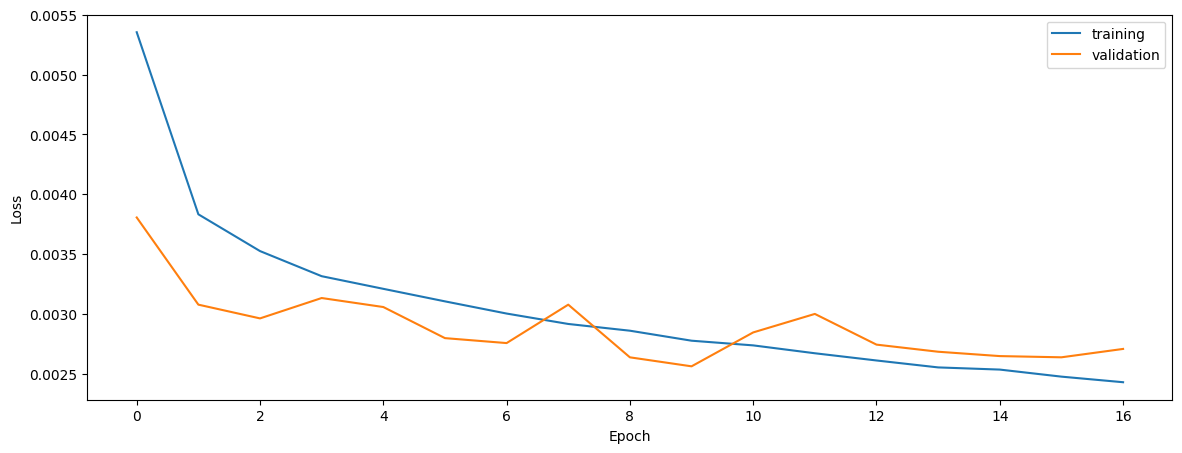

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.8448032705789178
0.8383760053899749
0.8240885710309382


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8454533940352813
0.8514151787969579
0.8285902728522552


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8432641655466425
0.8482047793143638
0.8270479933279028


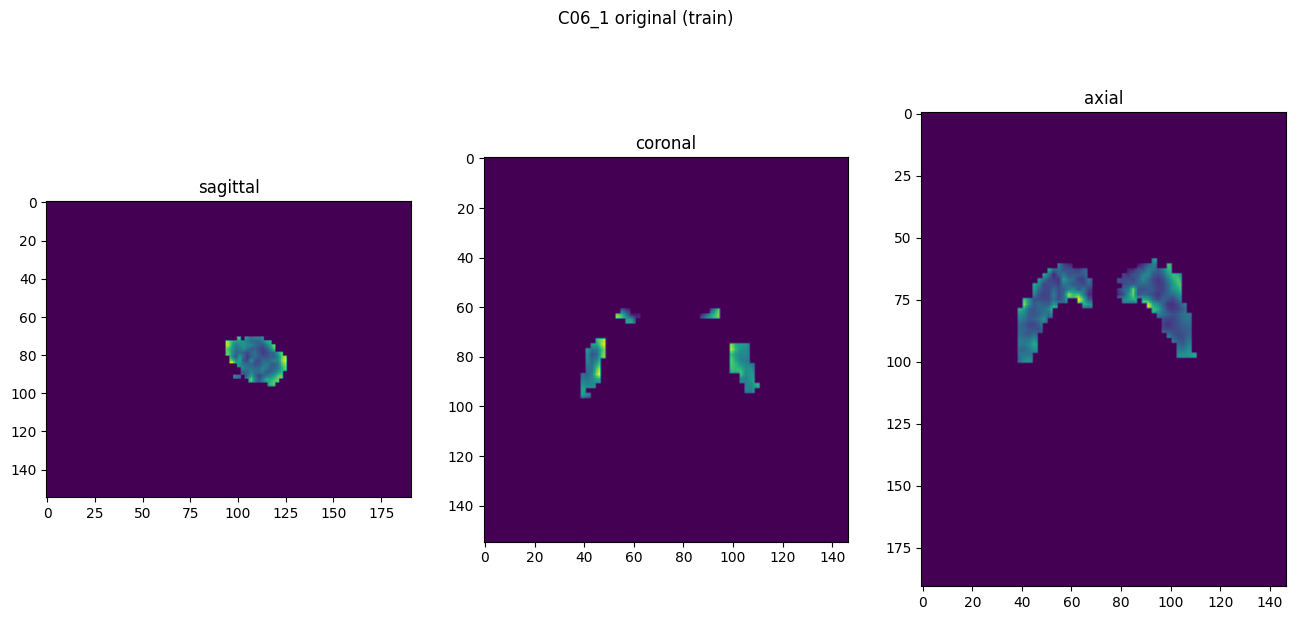

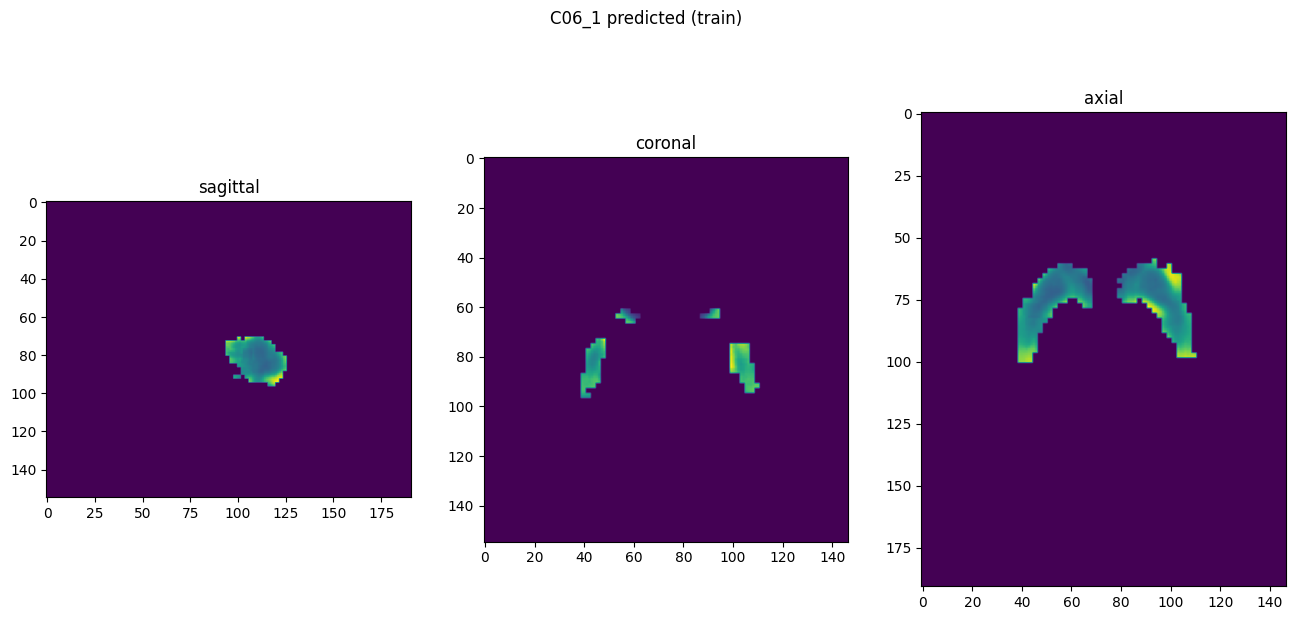

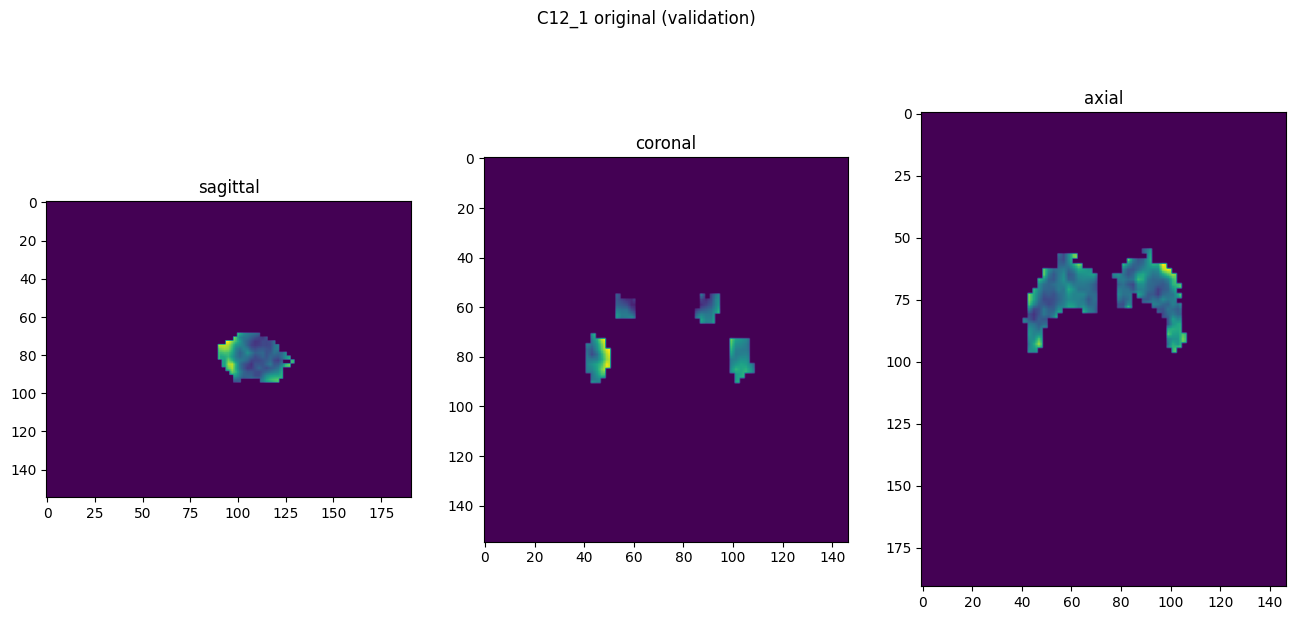

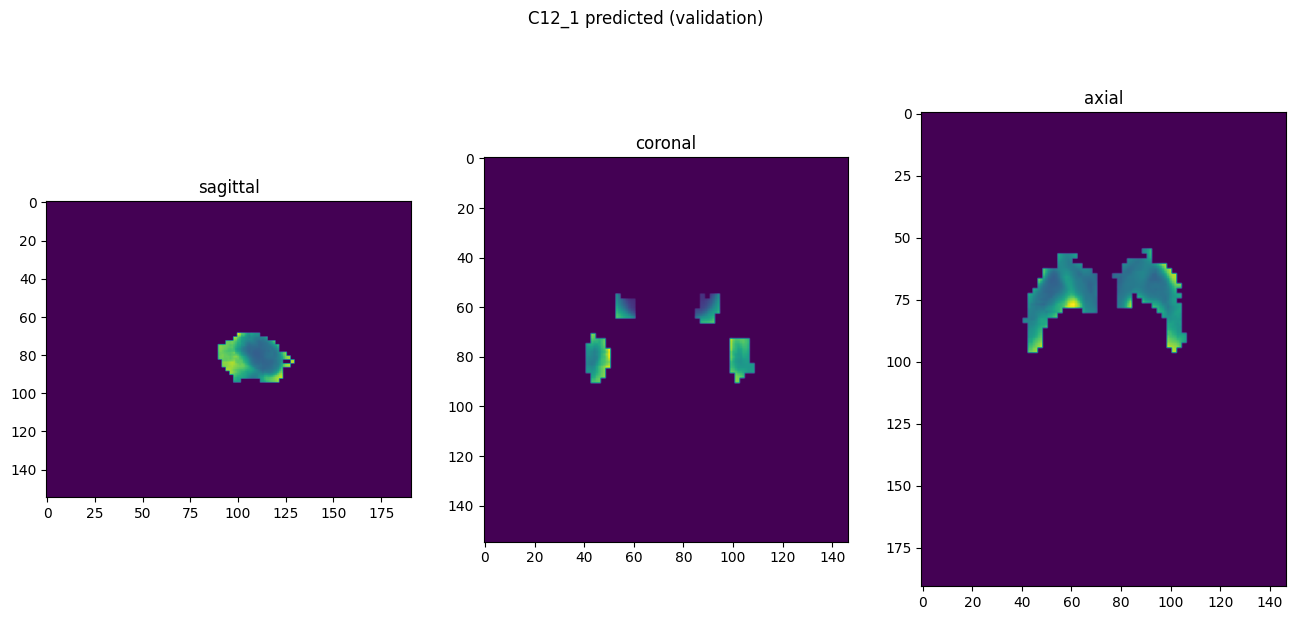

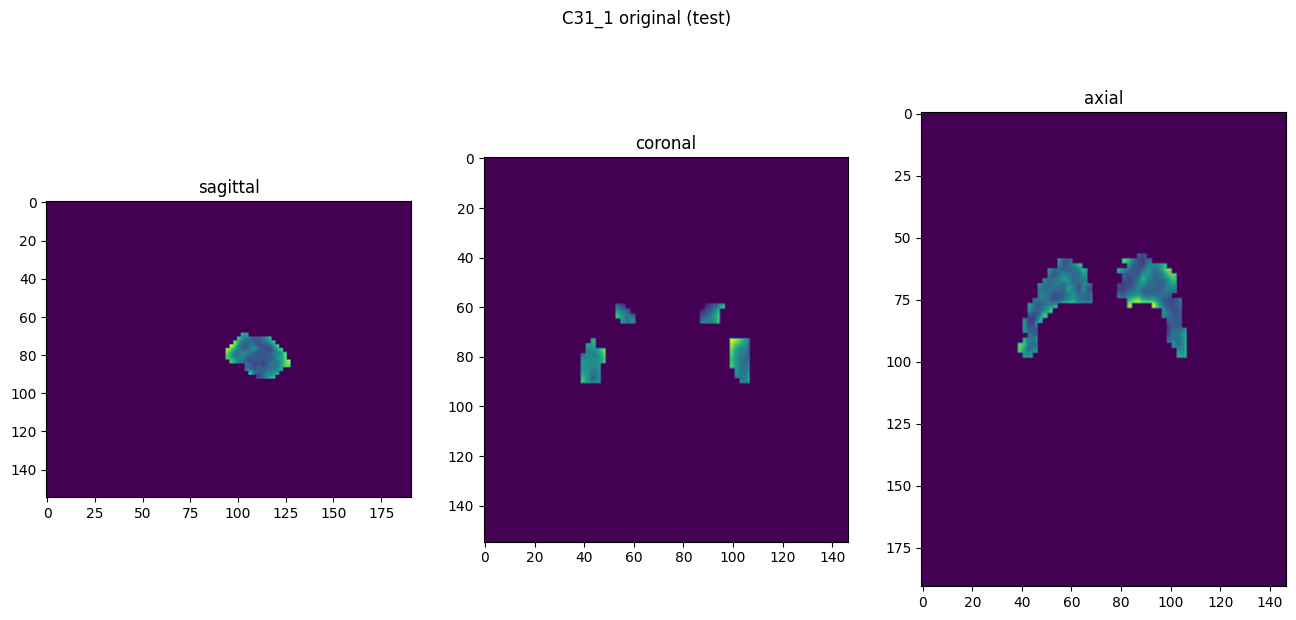

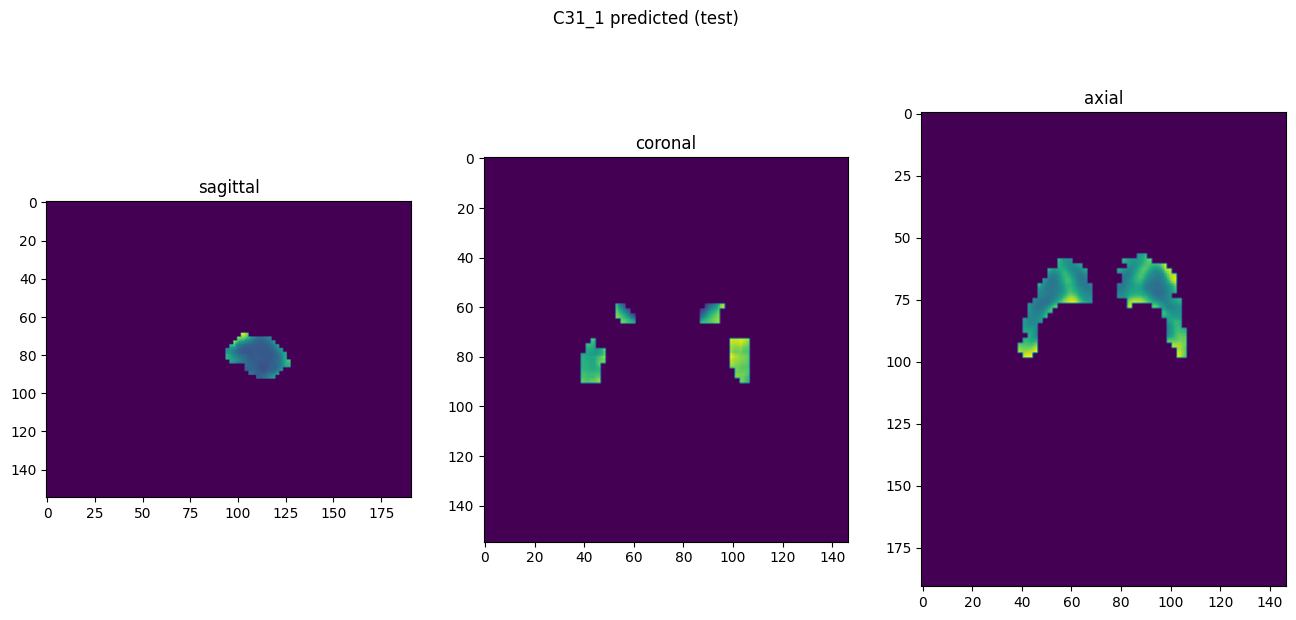

In [10]:
showResults(model, gen, threshold=None, background=False)